I want to see waht the HODs (and other things) look like in bigger v smaller boxes. 

In [22]:
from pearce.mocks.kittens import cat_dict
import numpy as np
from scipy.stats import binned_statistic, linregress

In [23]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [24]:
from halotools.sim_manager import HaloTableCache

cache = HaloTableCache()

In [25]:
cats = []
boxnos =  [0, 4,5,6,7,8,9,10]

for boxno in boxnos:
    cosmo_params = {'simname':'resolution','boxno': boxno, 'scale_factors':[0.8, 1.0]}

    cat = cat_dict[cosmo_params['simname']](**cosmo_params)#construct the specified catalog!
    print cat.version_name

    cat.load(1.0, tol = 0.01, HOD='redMagic', particles = False)#, hod_kwargs = {'sec_haloprop_key':'halo_log_nfw_conc'})#, hod_kwargs={'split': 0.5})
    cats.append(cat)

most_recent_00
most_recent_04
most_recent_05
most_recent_06
most_recent_07
most_recent_08
most_recent_09
most_recent_10


In [26]:
cosmo_params = {'simname':'chinchilla','Lbox': 400.0, 'scale_factors':[0.8112, 1.0]}

baseline_cat = cat_dict[cosmo_params['simname']](**cosmo_params)#construct the specified catalog!
baseline_cat.load(1.0, tol = 0.01, HOD='redMagic', particles = False)#, hod_kwargs = {'sec_haloprop_key':'halo_log_nfw_conc'})#, hod_kwargs={'split': 0.5})


In [27]:
params = {'logMmin': 13.33524467264376, 'logM0': 15.03992672969126, 'sigma_logM': 0.1956427400539345, 
 'logM1': 14.177074869254131, 'alpha': 0.9185255021020393}

In [28]:
mass_bin_range = (9, 16)
mass_bin_size = 0.1
massbins = np.logspace(mass_bin_range[0], mass_bin_range[1], int( (mass_bin_range[1]-mass_bin_range[0])/mass_bin_size )+1 )
mbc = (massbins[:-1]+massbins[1:])/2

In [29]:
from halotools.mock_observables import hod_from_mock

13.3352446726 11.819422842624085
13.3352446726 10.915115776192204


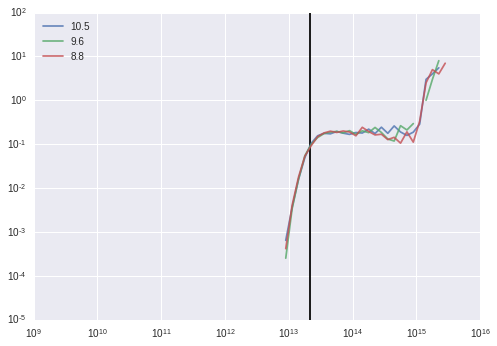

In [30]:
i=0
min_ptcl = 20
for label, cat in zip(boxnos, cats):
    print params['logMmin'], np.log10(cat.pmass*min_ptcl)
    cat.populate(params, min_ptcl = min_ptcl)
    galaxy_table = cat.model.mock.galaxy_table
    cenmask = galaxy_table['gal_type'] == 'centrals'
    halo_mass = cat.model.mock.halo_table['halo_mvir']
    cen_hod = hod_from_mock(galaxy_table['halo_mvir'][cenmask], halo_mass, massbins)[0]
    sat_hod = hod_from_mock(galaxy_table['halo_mvir'][~cenmask], halo_mass, massbins)[0]
    plt.plot(mbc, cen_hod + sat_hod ,label = '%.1f'%np.log10(cat.pmass), alpha = 0.8)
    i+=1
    if i > 1:
        break
        
baseline_cat.populate(params, min_ptcl = 200)
galaxy_table = baseline_cat.model.mock.galaxy_table
cenmask = galaxy_table['gal_type'] == 'centrals'
halo_mass = baseline_cat.model.mock.halo_table['halo_mvir']
cen_hod = hod_from_mock(galaxy_table['halo_mvir'][cenmask], halo_mass, massbins)[0]
sat_hod = hod_from_mock(galaxy_table['halo_mvir'][~cenmask], halo_mass, massbins)[0]
plt.plot(mbc, cen_hod + sat_hod ,label = '%.1f'%np.log10(baseline_cat.pmass), alpha = 0.8)
    
plt.vlines(10**params['logMmin'], 1e-5, 1e2 )
    
plt.legend(loc='best')
plt.loglog();

In [31]:
rbins = np.array([0.31622777, 0.44326829, 0.62134575, 0.87096359, 1.22086225, 1.7113283, 2.39883292, 3.36253386,\
                  4.71338954, 6.60693448, 9.26118728,  12.98175275, 18.19700859,  25.50742784,  35.75471605])#,  50.11872336])
rpoints = (rbins[1:]+rbins[:-1])/2

In [ ]:
lowres_xis = []
lowres_errs = []

highres_xis = []
highres_errs = []
n_repops = 25
for boxno, cat in zip(boxnos, cats):
    _xis = []
    for i in xrange(n_repops):
        cat.populate(params) # TODO repop a few times
        _xis.append(cat.calc_xi(rbins, do_jackknife = False))
    if boxno in set([0, 5,7,9]):
        lowres_xis.append(np.array(_xis).mean(axis = 0))
        lowres_errs.append(np.array(_xis).std(axis = 0))
    else:
        highres_xis.append(np.array(_xis).mean(axis = 0))
        highres_errs.append(np.array(_xis).std(axis = 0))
    #plt.plot(rbc, bias, alpha = 0.1, color = 'b')

In [ ]:
#plt.plot(tpoints, wt_redmagic, label = 'Buzzard Mock', color = 'r')
#plt.errorbar(rpoints, np.ones_like(rpoints), yerr=err, label = '%.1f'%np.log10(baseline_cat.pmass), capthick = 1, capsize = 5,
#                color = 'r')

plt.errorbar(rpoints, np.mean(np.array(lowres_xis)/np.array(highres_xis), axis = 0),\
             yerr=np.sqrt(np.mean(np.array(lowres_errs)**2, axis = 0)), capthick = 1, capsize = 5)

#plt.plot(rpoints, xi/baseline_xi, label = '%.1f'%np.log10(cat.pmass), color = c)#, capthick = 1, capsize = 5)
plt.ylabel(r'$\xi_{low res}(r)/\xi_{high res}(r)$')
plt.xlabel(r'$r \mathrm{[Mpc]}$')
plt.xscale('log');
plt.legend(loc='best')
plt.title(r'$\log{M_{min}}=$%0.2f    Min Particles = %d'%(params['logMmin'], min_ptcl))
plt.xlim([0.1, 40])
plt.ylim([0.5, 2.5])

plt.show()

In [ ]:
from halotools.mock_observables import tpcf, return_xyz_formatted_array

In [ ]:
lowres_xis = []
#lowres_errs = []

highres_xis = []
#highres_errs = []
min_mass = cats[0].pmass*100
for boxno, cat in zip(boxnos, cats):
    ht = cat.halocat.halo_table
    x,y,z = [ht[c] for c in ['halo_x', 'halo_y', 'halo_z']]
    pos = return_xyz_formatted_array(x, y, z, period=cat.Lbox)
    mask = ht['halo_mvir'] > min_mass
    pos = pos[mask]
    xi = tpcf(pos, rbins, period=cat.Lbox, num_threads=4, estimator='Landy-Szalay')
    if boxno in set([0, 5,7,9]):
        lowres_xis.append(xi)
        #lowres_errs.append(np.array(_xis).std(axis = 0))
    else:
        highres_xis.append(xi)
        #highres_errs.append(np.array(_xis).std(axis = 0))
    #plt.plot(rbc, bias, alpha = 0.1, color = 'b')

In [ ]:
#plt.plot(tpoints, wt_redmagic, label = 'Buzzard Mock', color = 'r')
#plt.errorbar(rpoints, np.ones_like(rpoints), yerr=err, label = '%.1f'%np.log10(baseline_cat.pmass), capthick = 1, capsize = 5,
#                color = 'r')

plt.errorbar(rpoints, np.mean(np.array(lowres_xis)/np.array(highres_xis), axis = 0),\
             yerr=np.sqrt(np.mean(np.array(lowres_errs)**2, axis = 0)), capthick = 1, capsize = 5)

#plt.plot(rpoints, xi/baseline_xi, label = '%.1f'%np.log10(cat.pmass), color = c)#, capthick = 1, capsize = 5)
plt.ylabel(r'$\xi_{low res}(r)/\xi_{high res}(r)$')
plt.xlabel(r'$r \mathrm{[Mpc]}$')
plt.xscale('log');
plt.legend(loc='best')
plt.title(r'Min Particles = %d Low Res'%(min_ptcl))
plt.xlim([0.1, 40])
plt.ylim([0.0, 2.0])

plt.show()

In [ ]:
#plt.plot(tpoints, wt_redmagic, label = 'Buzzard Mock', color = 'r')
#plt.errorbar(rpoints, np.ones_like(rpoints), yerr=err, label = '%.1f'%np.log10(baseline_cat.pmass), capthick = 1, capsize = 5,
#                color = 'r')

plt.plot(rpoints, np.mean(lowres_xis, axis = 0), label = "Low" )
plt.plot(rpoints, np.mean(highres_xis, axis = 0), label = "High")

#plt.plot(rpoints, xi/baseline_xi, label = '%.1f'%np.log10(cat.pmass), color = c)#, capthick = 1, capsize = 5)
plt.ylabel(r'$\xi_{hh}(r)$')
plt.xlabel(r'$r \mathrm{[Mpc]}$')
plt.loglog()
plt.legend(loc='best')
plt.title(r' Min Particles = %d'%( min_ptcl))
plt.xlim([0.1, 40])
#plt.ylim([0.5, 2.5])

plt.show()

In [ ]:
#plt.plot(tpoints, wt_redmagic, label = 'Buzzard Mock', color = 'r')
plt.errorbar(rpoints, np.ones_like(rpoints), yerr=baseline_err, label = '%.1f'%np.log10(cats[0].pmass), capthick = 1, capsize = 5,
                color = 'r')

for boxno,cat, xi,err in zip(boxnos,cats, xis, errs):
    #if boxno<4:
    #    break
    c = 'g' if np.log10(cat.pmass) < 10 else 'b'
    #plt.errorbar(rpoints, xi/baseline_xi, yerr=err, label = '%.1f'%np.log10(cat.pmass),color=c, capthick = 1, capsize = 5)
    
    plt.plot(rpoints, xi/xis[0], label = '%.1f'%np.log10(cat.pmass), color = c)#, capthick = 1, capsize = 5)

plt.ylabel(r'$\xi(r)/\xi_{baseline}(r)$')
plt.xlabel(r'$r \mathrm{[Mpc]}$')
plt.xscale('log');
plt.legend(loc='best')
plt.title(r'$\log{M_{min}}=$%0.2f    Min Particles = %d'%(params['logMmin'], min_ptcl))
plt.xlim([0.1, 40])
plt.ylim([0, 2])

plt.show()

In [ ]:
for boxno, xi in zip(boxnos, xis):
    plt.plot(rpoints, xi, alpha = 0.8, label = boxno)
    
#plt.plot(tpoints, wt_redmagic, label = 'Buzzard Mock', color = 'r')


plt.ylabel(r'$\xi(r)$')
plt.xlabel(r'$r \mathrm{[Mpc/h]}$')
plt.loglog();
plt.legend(loc='best')
#plt.xlim([4e-2, 4])
plt.show()